## Overview of how the Stubble Burning Dataset was created using GEE

This notebook utilizes datasets created using Google Earth Engine. It has been designed to facilitate the detection of stubble burning in the agricultural regions of Punjab. The process leverages satellite imagery and active fire observations spanning several years (2019-2024) to build a comprehensive collection of data representing both areas affected by burning and those that remained unburned.

The initial phase involved defining the geographical scope of our analysis, focusing on a large area encompassing key agricultural zones within Punjab. We also established a consistent timeframe for analysis each year, specifically the burning season which typically occurs between September and December. To ensure our focus remained on agricultural activities, we incorporated a pre-existing map identifying cropland areas, effectively masking out non-agricultural land.

The core of the dataset generation process centered around identifying locations indicative of stubble burning. This was achieved by analyzing active fire data obtained from satellites. When these fire locations coincided with our defined cropland areas, they were labeled as 'burned' sample points. To provide a comparative dataset for training a detection model, we also identified 'unburned' sample points. These were selected as random locations within the cropland areas that were a certain distance away from any detected fires, ensuring they likely represented undisturbed farmland.

Around each of these identified burned and unburned locations, we created small virtual buffer zones. These zones served as areas from which to extract relevant information from satellite imagery. For each burning season, we processed optical imagery (like that from Sentinel-2, which captures visible and infrared light). From the optical imagery, we calculated key indicators such as the Normalized Difference Vegetation Index (NDVI) and the Normalized Burn Ratio (NBR), which are sensitive to vegetation health and burn severity.

The culmination of this process was the creation of a structured dataset. This information is organized in a tabular format, making it suitable for training DL models to distinguish between burned and unburned agricultural fields.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
import os
import glob

burned_files = glob.glob("dataset/Burned_ValidTimeSeries_*.csv")
unburned_files = glob.glob("dataset/Unburned_ValidTimeSeries_*.csv")
all_files = burned_files + unburned_files
dfs = []

for file in all_files:
    print(f"Processing {file}...")
    df = pd.read_csv(file)
    df['point_id'] = df['point_id'].astype(str)
    df['location_id'] = df['year'].astype(str) + "_" + df['point_id']
    
    # Add to list
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)
combined_df['date'] = pd.to_datetime(combined_df['date'])
combined_df = combined_df.sort_values(['location_id', 'date'])
combined_df.to_csv("combined_timeseries_dataset.csv", index=False)

print(f"\nCombined dataset successfully created!")
print(f"Total observations: {len(combined_df)}")
print(f"Unique locations: {combined_df['location_id'].nunique()}")
print(f"Date range: {combined_df['date'].min()} to {combined_df['date'].max()}")
print(f"Burned samples: {(combined_df['burn_status'] == 1).sum()} ({(combined_df['burn_status'] == 1).sum() / len(combined_df) * 100:.2f}%)")
print(f"Unburned samples: {(combined_df['burn_status'] == 0).sum()} ({(combined_df['burn_status'] == 0).sum() / len(combined_df) * 100:.2f}%)")

Processing dataset/Burned_ValidTimeSeries_2023.csv...
Processing dataset/Burned_ValidTimeSeries_2022.csv...
Processing dataset/Burned_ValidTimeSeries_2020.csv...
Processing dataset/Burned_ValidTimeSeries_2021.csv...
Processing dataset/Burned_ValidTimeSeries_2019.csv...
Processing dataset/Burned_ValidTimeSeries_2024.csv...
Processing dataset/Unburned_ValidTimeSeries_2021.csv...
Processing dataset/Unburned_ValidTimeSeries_2020.csv...
Processing dataset/Unburned_ValidTimeSeries_2022.csv...
Processing dataset/Unburned_ValidTimeSeries_2023.csv...
Processing dataset/Unburned_ValidTimeSeries_2024.csv...
Processing dataset/Unburned_ValidTimeSeries_2019.csv...

Combined dataset successfully created!
Total observations: 57062
Unique locations: 2768
Date range: 2019-09-03 00:00:00 to 2024-12-30 00:00:00
Burned samples: 22113 (38.75%)
Unburned samples: 34949 (61.25%)


Sample data:


,system:index,burn_status,date,point_id,year,tile_id,NDVI,NBR,B4,B8,B11,location_id
0,0_20190903T054641_20190903T054638_T43SCR,0,2019-09-03,0,2019,20190903T054641_20190903T054638_T43SCR,0.588911,0.238880,950.257510,3651.452189,2251.679069,2019_0
1,0_20190913T054641_20190913T055834_T43SCR,0,2019-09-13,0,2019,20190913T054641_20190913T055834_T43SCR,0.517485,0.322792,902.925191,2824.247398,1447.052818,2019_0
2,0_20190918T054639_20190918T055537_T43SCR,0,2019-09-18,0,2019,20190918T054639_20190918T055537_T43SCR,0.621580,0.221236,784.568624,3313.495582,2116.549971,2019_0
3,0_20191008T054719_20191008T055844_T43SCR,0,2019-10-08,0,2019,20191008T054719_20191008T055844_T43SCR,0.449862,0.119455,934.798449,2464.832417,1909.463283,2019_0
4,0_20191013T054801_20191013T055222_T43SCR,0,2019-10-13,0,2019,20191013T054801_20191013T055222_T43SCR,0.341308,0.078328,1157.688985,2346.192421,2000.784606,2019_0



Basic statistics for numerical features:


,burn_status,year,NDVI,NBR,B4,B8,B11
count,57062.000000,57062.000000,57062.000000,57062.000000,57062.000000,57062.000000,57062.000000
mean,0.387526,2021.649311,0.356057,0.100193,1568.279342,3283.490544,2648.469657
std,0.487190,1.668593,0.229191,0.176373,742.147425,1023.495875,830.052977
min,0.000000,2019.000000,-0.184660,-0.345697,32.422404,458.635148,272.442686
25%,0.000000,2020.000000,0.151122,-0.054709,1088.231960,2546.953699,2025.086259
50%,0.000000,2022.000000,0.314357,0.072514,1497.143574,3263.360606,2632.417410
75%,1.000000,2023.000000,0.523946,0.248624,2055.032622,3992.585453,3127.761671
max,1.000000,2024.000000,0.969071,0.640151,11680.230004,10615.370112,9058.379375



Burn status distribution (by locations):


burn_status
0    1384
1    1384
Name: count, dtype: int64

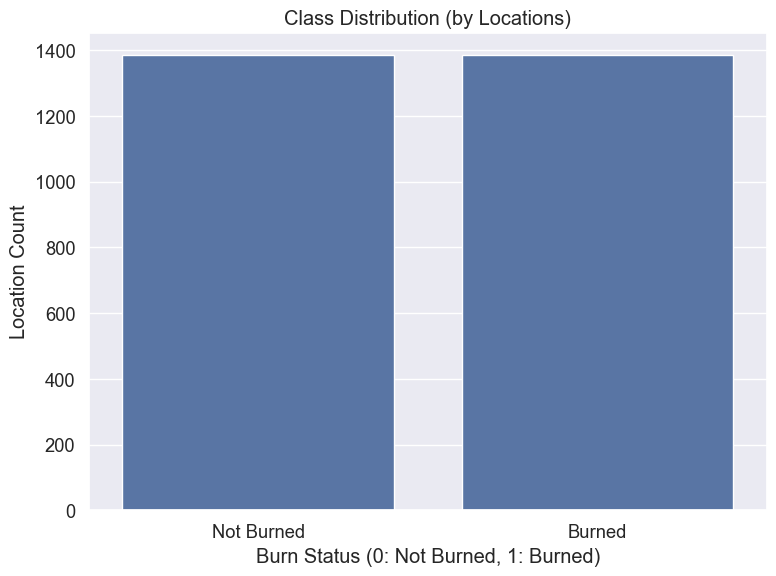

Class imbalance ratio by locations (Not Burned : Burned): 1.00 : 1
Year distribution:


year
2019     6407
2020    10654
2021    11193
2022     8449
2023     9007
2024    11352
Name: count, dtype: int64

Distribution by year and burn status:


burn_status,0,1
year,,
2019,3987,2420
2020,6540,4114
2021,6595,4598
2022,5169,3280
2023,5602,3405
2024,7056,4296


Total unique locations: 2768

Time points per location statistics:


count    2768.000000
mean       18.335983
std         6.794456
min         6.000000
25%        15.000000
50%        17.000000
75%        19.000000
max        43.000000
Name: date, dtype: float64

Number of burned locations: 1384
Number of non-burned locations: 1384

Time points for burned locations:


count    1384.000000
mean       15.814306
std         2.973160
min        10.000000
25%        15.000000
50%        17.000000
75%        18.000000
max        19.000000
Name: date, dtype: float64


Time points for non-burned locations:


count    1384.000000
mean       20.857659
std         8.414040
min         6.000000
25%        16.000000
50%        18.000000
75%        26.000000
max        43.000000
Name: date, dtype: float64

Mean feature values by burn status:


,NDVI,NBR,B4,B8,B11
burn_status,,,,,
0,0.342499,0.081803,1632.149641,3261.415408,2759.512714
1,0.377486,0.129257,1467.334058,3318.379701,2472.969100


Training locations: 2214
Validation locations: 277
Testing locations: 277


In [ ]:
np.random.seed(42)

data_path = 'combined_timeseries_dataset.csv'
df = pd.read_csv(data_path)

print("Sample data:")
display(df.head())


print("\nBasic statistics for numerical features:")
display(df.describe())



location_burn_status = df.groupby('location_id')['burn_status'].first()
location_burn_counts = location_burn_status.value_counts()
print("\nBurn status distribution (by locations):")
display(location_burn_counts)


plt.figure(figsize=(8, 6))


sns.countplot(data=pd.DataFrame({'burn_status': location_burn_status}), x='burn_status')
plt.title('Class Distribution (by Locations)')
plt.xlabel('Burn Status (0: Not Burned, 1: Burned)')
plt.ylabel('Location Count')
plt.xticks([0, 1], ['Not Burned', 'Burned'])

plt.tight_layout()
plt.show()


location_imbalance = location_burn_counts[0] / location_burn_counts[1] if 1 in location_burn_counts else float('inf')

print(f"Class imbalance ratio by locations (Not Burned : Burned): {location_imbalance:.2f} : 1")


year_counts = df['year'].value_counts().sort_index()
print("Year distribution:")
display(year_counts)


year_burn_counts = df.groupby(['year', 'burn_status']).size().unstack(fill_value=0)
print("Distribution by year and burn status:")
display(year_burn_counts)



locations = df['location_id'].unique()
print(f"Total unique locations: {len(locations)}")

location_timepoints = df.groupby('location_id')['date'].nunique()
print("\nTime points per location statistics:")
display(location_timepoints.describe())

location_burn_status = df.groupby('location_id')['burn_status'].first()
burned_locations = location_burn_status[location_burn_status == 1].index
nonburned_locations = location_burn_status[location_burn_status == 0].index

print(f"Number of burned locations: {len(burned_locations)}")
print(f"Number of non-burned locations: {len(nonburned_locations)}")

burned_timepoints = location_timepoints[burned_locations]
nonburned_timepoints = location_timepoints[nonburned_locations]

print("\nTime points for burned locations:")
display(burned_timepoints.describe())

print("\nTime points for non-burned locations:")
display(nonburned_timepoints.describe())

spectral_features = ['NDVI', 'NBR', 'B4', 'B8', 'B11']

feature_means = df.groupby('burn_status')[spectral_features].mean()
print("Mean feature values by burn status:")
display(feature_means)

sample_burned_locs = np.random.choice(burned_locations, min(5, len(burned_locations)), replace=False)
sample_nonburned_locs = np.random.choice(nonburned_locations, min(5, len(nonburned_locations)), replace=False)


train_locs, test_locs = train_test_split(locations, test_size=0.2, random_state=42, 
                                         stratify=location_burn_status)
valid_locs, test_locs = train_test_split(test_locs, test_size=0.5, random_state=42)

print(f"Training locations: {len(train_locs)}")
print(f"Validation locations: {len(valid_locs)}")
print(f"Testing locations: {len(test_locs)}")

